In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
pip install missingno

  Obtaining dependency information for missingno from https://files.pythonhosted.org/packages/87/22/cd5cf999af21c2f97486622c551ac3d07361ced8125121e907f588ff5f24/missingno-0.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/8b/d2/78e3342f5db363ddf92de84007d43e47c8bb24363bd509e1b75a5102a25d/scipy-1.14.0-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 1.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/6c/97/dfc635bd435655c1216756b543e0427579df144914a055a188d3c0ffd52f/scikit_learn-1.5.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 1.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 1.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packag

In [6]:
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


In [7]:
def load_application_train():
    data = pd.read_csv("Mall_Customers.csv")
    return data

In [8]:
df = load_application_train()
print(df.shape) 

(200, 5)


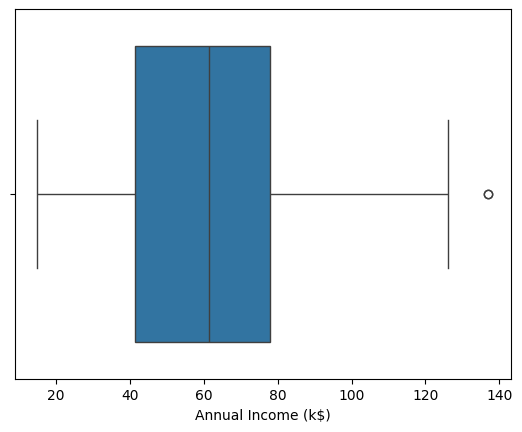

In [14]:
sns.boxplot(x=df["Annual Income (k$)"])
plt.show()

In [15]:
q1 = df["Annual Income (k$)"].quantile(0.25)
q3 = df["Annual Income (k$)"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

In [16]:
print(df[(df["Annual Income (k$)"] < low) | (df["Annual Income (k$)"] > up)])

     CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)
198         199   Male   32                 137                      18
199         200   Male   30                 137                      83


In [17]:
print(df[(df["Annual Income (k$)"] < low) | (df["Annual Income (k$)"] > up)].index)

Index([198, 199], dtype='int64')


In [18]:
print(df[(df["Annual Income (k$)"] < low) | (df["Annual Income (k$)"] > up)].any(axis=None))

True


In [19]:
print(df[(df["Annual Income (k$)"] < low)].any(axis=None))

False


In [20]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [21]:
print(outlier_thresholds(df, "Annual Income (k$)"))

(np.float64(-13.25), np.float64(132.75))


In [23]:
low, up = outlier_thresholds(df, "Age")
print(df[(df["Age"] < low) | (df["Age"] > up)].head())

Empty DataFrame
Columns: [CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)]
Index: []


In [24]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [25]:
print(check_outlier(df, "Age")) 
print(check_outlier(df, "Annual Income (k$)"))

False
True


In [27]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [28]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 200
Variables: 5
cat_cols: 1
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [29]:
num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)

['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [30]:
for col in num_cols:
    print(col, check_outlier(df, col))

CustomerID False
Age False
Annual Income (k$) True
Spending Score (1-100) False


In [33]:
dff = load_application_train()

cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 200
Variables: 5
cat_cols: 1
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [34]:
for col in num_cols:
    print(col, check_outlier(dff, col))

CustomerID False
Age False
Annual Income (k$) True
Spending Score (1-100) False


In [35]:
def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index

In [36]:
age_index = grab_outliers(df, "Age", True)

Empty DataFrame
Columns: [CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100)]
Index: []


In [37]:
print(age_index)

Index([], dtype='int64')


In [40]:
low, up = outlier_thresholds(df, "Age")

In [41]:
print(df.shape)

(200, 5)


In [42]:
print(df[~((df["Age"] < low) | (df["Age"] > up))].shape)

(200, 5)


In [43]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [44]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 200
Variables: 5
cat_cols: 1
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [45]:
num_cols.remove('CustomerID')

In [46]:
for col in num_cols:
    df = remove_outlier(df,col)

In [47]:
print(df.shape)

(198, 5)


In [48]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
